In [11]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [12]:
train_df = pd.read_csv('data/UNSW_NB15_training.csv')
test_df = pd.read_csv('data/UNSW_NB15_testing.csv')

In [13]:
# Assuming 'X' is your feature set and 'y' is your target
target = 'attack_cat'
features = [ "sbytes", "smean", "sttl", "dtcpb", "stcpb", "dbytes",
    "ct_srv_dst", "dload", "response_body_len", "ackdat", "dmean", "dur",
    "sload", "ct_srv_src", "synack", "dloss", "ct_dst_src_ltm", "sjit", "proto", "service", "state"
]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

In [14]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [15]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Features:", categorical_features)

Categorical Features: ['proto', 'service', 'state']


In [16]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    auto_class_weights='Balanced',
    verbose=100
)

# Train with categorical features specified
model.fit(X_train, y_train, cat_features=categorical_features, eval_set=(X_test, y_test), early_stopping_rounds=50)

0:	learn: 0.7075726	test: 0.7075726	best: 0.7075726 (0)	total: 52.6ms	remaining: 52.5s
100:	learn: 0.8439860	test: 0.8437138	best: 0.8440787 (99)	total: 5.43s	remaining: 48.3s
200:	learn: 0.8662011	test: 0.8656255	best: 0.8664475 (194)	total: 10.5s	remaining: 41.8s
300:	learn: 0.9101623	test: 0.9087464	best: 0.9089543 (299)	total: 15.4s	remaining: 35.8s
400:	learn: 0.9298054	test: 0.9286929	best: 0.9286929 (400)	total: 20.2s	remaining: 30.1s
500:	learn: 0.9392847	test: 0.9379709	best: 0.9379709 (500)	total: 25.1s	remaining: 25s
600:	learn: 0.9464328	test: 0.9451520	best: 0.9451520 (600)	total: 29.9s	remaining: 19.8s
700:	learn: 0.9521830	test: 0.9506300	best: 0.9507359 (699)	total: 34.6s	remaining: 14.7s
800:	learn: 0.9580766	test: 0.9561456	best: 0.9562826 (797)	total: 39.3s	remaining: 9.76s
900:	learn: 0.9610696	test: 0.9595497	best: 0.9600641 (897)	total: 44.1s	remaining: 4.84s
999:	learn: 0.9629616	test: 0.9613643	best: 0.9617443 (982)	total: 48.7s	remaining: 0us

bestTest = 0.9617

In [17]:
y_pred = model.predict(X_test)

In [18]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9409066666666667
                precision    recall  f1-score   support

      Backdoor       0.79      1.00      0.88        83
           DoS       0.88      0.91      0.89      1216
       Fuzzers       0.78      0.96      0.86       836
       Generic       0.88      1.00      0.94       289
        Normal       1.00      0.93      0.96      5348
Reconnaissance       0.94      0.97      0.96      1603

      accuracy                           0.94      9375
     macro avg       0.88      0.96      0.92      9375
  weighted avg       0.95      0.94      0.94      9375



In [19]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# Display top 10 important features
important_features = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
print(important_features.sort_values(by="Importance", ascending=False))

              Feature  Importance
0              sbytes   12.540742
1               smean    8.055733
9              ackdat    7.528744
2                sttl    7.140500
14             synack    6.917090
5              dbytes    6.140008
10              dmean    5.655818
4               stcpb    5.270881
3               dtcpb    5.109082
6          ct_srv_dst    5.013236
7               dload    4.677776
8   response_body_len    4.599335
11                dur    4.524358
12              sload    4.125449
13         ct_srv_src    3.969528
17               sjit    3.770154
16     ct_dst_src_ltm    2.370913
15              dloss    2.158056
20              state    0.432598
18              proto    0.000000
19            service    0.000000


In [20]:
import catboost
model.save_model("catboost_model.cbm")

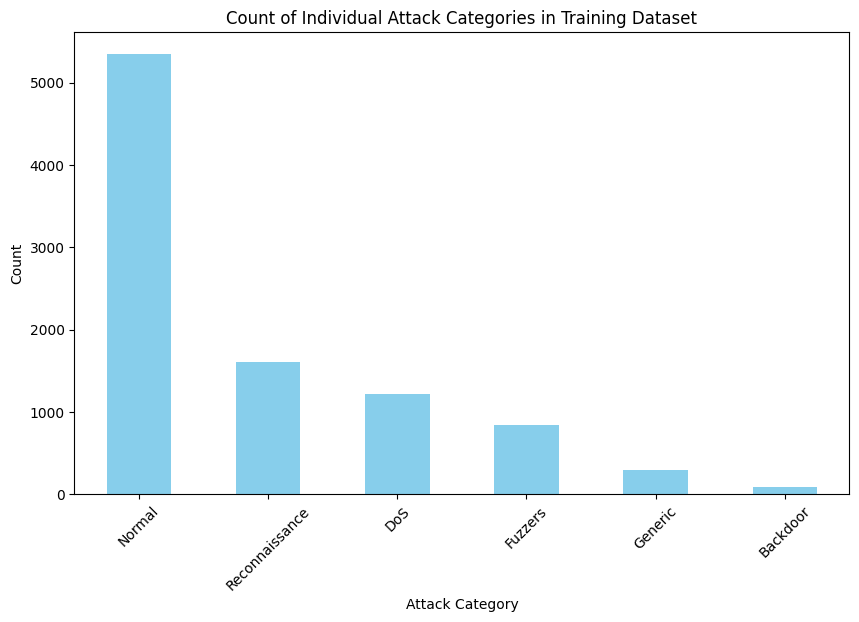

In [21]:
import matplotlib.pyplot as plt

# Count the occurrences of each attack category
attack_counts = train_df['attack_cat'].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
attack_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Individual Attack Categories in Training Dataset')
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [22]:
attack_percentage = (attack_counts / train_df.shape[0]) * 100
print(attack_percentage)

attack_cat
Normal            57.045333
Reconnaissance    17.098667
DoS               12.970667
Fuzzers            8.917333
Generic            3.082667
Backdoor           0.885333
Name: count, dtype: float64


In [23]:
test_model = CatBoostClassifier()
test_model.load_model("catboost_model.cbm")  # Example: "dos_detection_model.cbm"

# Define input features
dos_input = {
    "sbytes": 42398,
    "smean": 1116,
    "sttl": 254,
    "dtcpb": 891211352,
    "stcpb": 2591162142,
    "dbytes": 440,
    "ct_srv_dst": 1,
    "dload": 12656.10449,
    "response_body_len": 0,
    "ackdat": 0.043024,
    "dmean": 44,
    "dur": 0.250314,
    "sload": 1319398.875,
    "ct_srv_src": 1,
    "synack": 0.008289,
    "dloss": 1,
    "ct_dst_src_ltm": 1,
    "sjit": 610.994218,
    "proto": "tcp",
    "service": "http",
    "state": "FIN"
}

# Convert input to DataFrame
input_df = pd.DataFrame([dos_input])

# Predict
prediction = model.predict(input_df)
print("Predicted class:", prediction[0])

# Optional: Predict probabilities
proba = model.predict_proba(input_df)
print("Probabilities:", proba[0])

Predicted class: ['DoS']
Probabilities: [7.01893523e-04 9.75456125e-01 1.33921919e-02 6.58138081e-03
 2.82490484e-03 1.04350406e-03]


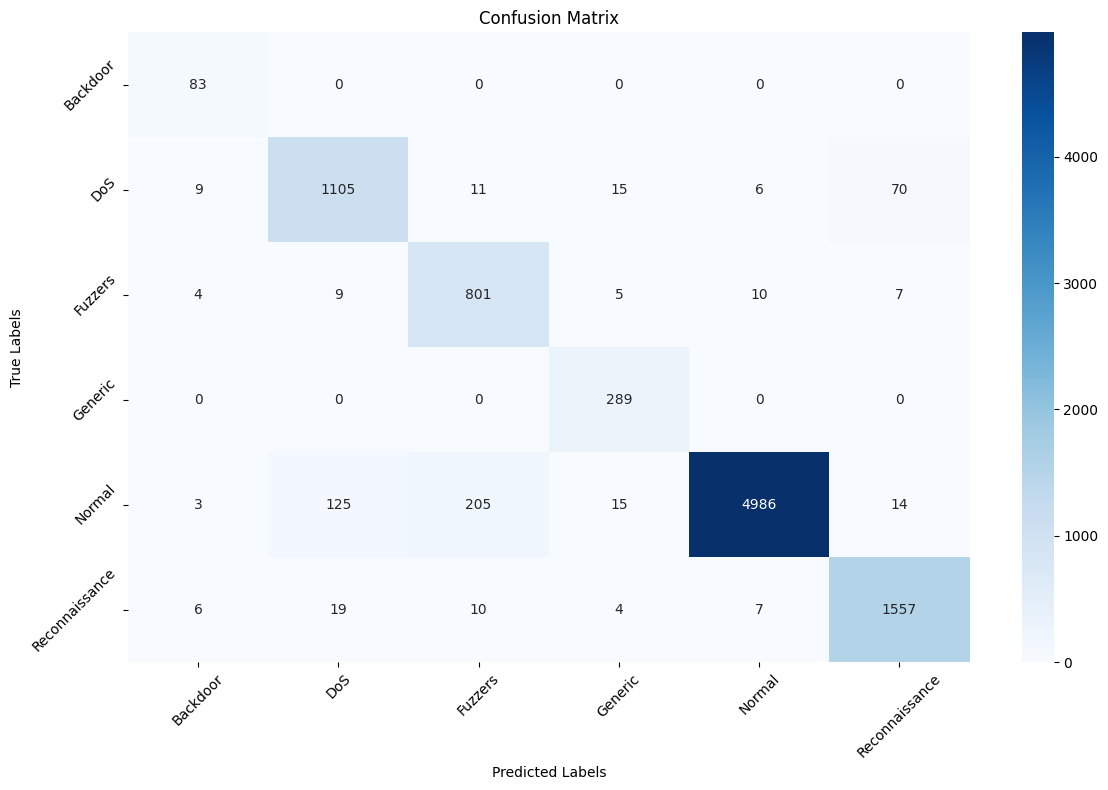

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


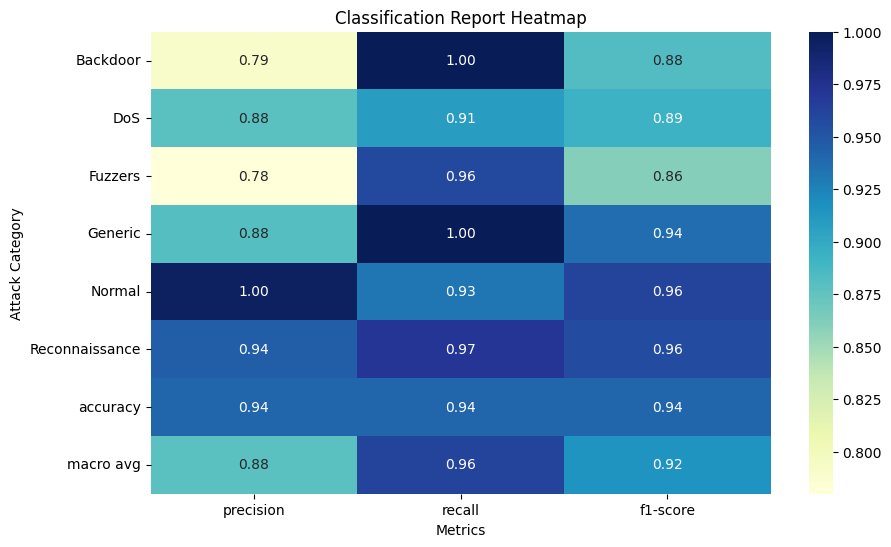

In [26]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Convert report to dict for visualization
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Attack Category")
plt.show()


C:\Users\LLOYD\AppData\Local\Temp\ipykernel_15088\1970365875.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


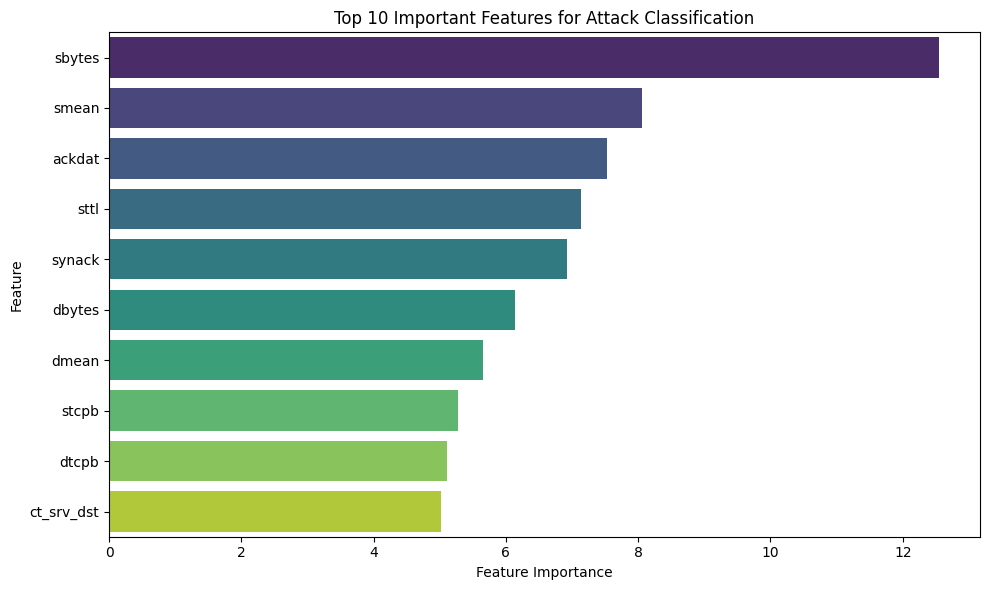

In [27]:
# Top 10 features
top_features = important_features.sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title("Top 10 Important Features for Attack Classification")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


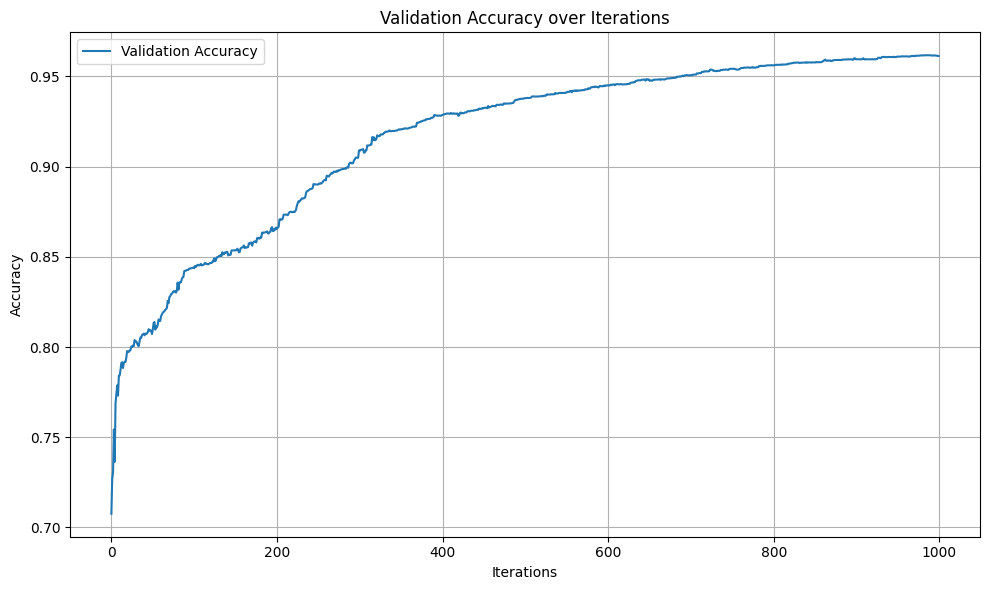

In [28]:
# Plotting learning curve from CatBoost's log
plt.figure(figsize=(10, 6))
plt.plot(model.get_evals_result()['validation']['Accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
